In [60]:
#Importing necessary libraries

from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FF0x\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
#Connecting to the Mongo Database to get the data

client = MongoClient(port=27017)
db = client.trip_advisor
collection = db.reviews_new
df = pd.DataFrame(list(collection.find()))

In [62]:
df.head()

,_id,poi_name,title,date,review_rating,text,date_of_visit,reviewer
0,"{'id': '822488814', 'poi_location_id': '380729...",To Tsai Thessaloniki,"Delicious tea, for tea lovers","December 19, 2021",50,"If you are a tea lover , this is the place to ...",December 2021,"{'name': 'Stefanos B', 'handle': 'stefanosb114..."
1,"{'id': '821022146', 'poi_location_id': '107988...",Koukos,Tasty croissants,"December 4, 2021",50,"The place has incredible decoration, very uniq...",October 2021,"{'name': 'Jimmys', 'handle': 'Poliorkitis96', ..."
2,"{'id': '831588926', 'poi_location_id': '151171...",Judah Club,WOW!,"March 18, 2022",50,Store and cafe - 5/5. Food and food presentati...,March 2022,"{'name': 'Reza S', 'handle': '392rezas', 'cont..."
3,"{'id': '793282537', 'poi_location_id': '380729...",To Tsai Thessaloniki,Awesome place!,"June 20, 2021",50,"The staff was amazing, the tea sublime and the...",June 2021,"{'name': 'Dee', 'handle': 'deesvs', 'location'..."
4,"{'id': '802555010', 'poi_location_id': '107988...",Koukos,Great pastry and sandwich shop,"August 8, 2021",50,Went to this shop out of curiosity and to try ...,August 2021,"{'name': 'Stefan Laurentiu', 'handle': 'stefan..."


In [63]:
# Create subset of users with age group info
age_subset = []

for item in collection.find():
    reviewer = item['reviewer']
    try:
        age_group = reviewer['age']
        age_subset.append(item)
    except:
        None

len(age_subset)

331

In [64]:
# Create subset of users with gender info
gender_subset = []

for item in collection.find():
    reviewer = item['reviewer']
    try:
        gender_group = reviewer['sex']
        gender_subset.append(reviewer)
        
    except:
        None

len(gender_subset)

419

In [65]:
# Preprocessing text data ( Tokenization, removing stop words,lower case conversion) 


#for item in collection.find():
    #text = item['text']
    #text_tokens = word_tokenize(text)
    #tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]   
    #print(tokens_without_sw)

    #filtered_sentence = (" ").join(tokens_without_sw).lower()
    #df["filtered_text"] = filtered_sentence
    #print(filtered_sentence)


In [66]:
dataf = pd.DataFrame(gender_subset)
print(dataf.isnull().sum())

name                0
handle              0
location            0
sex                 0
contributions      26
cities_visited     26
age                98
helpful_votes      50
photo             149
distribution       20
dtype: int64


In [67]:
# Dealing with missing values

updated_df = dataf.dropna(subset=['age'])
updated_df = updated_df.reset_index(drop= True)
updated_df['contributions']=updated_df['contributions'].fillna(updated_df['contributions'].mean())
updated_df['cities_visited']=updated_df['cities_visited'].fillna(updated_df['cities_visited'].mean())
updated_df['helpful_votes']=updated_df['helpful_votes'].fillna(updated_df['helpful_votes'].mean())
updated_df['photo']=updated_df['photo'].fillna(updated_df['photo'].mean())
updated_df.dropna(subset=['distribution'], inplace=True)
updated_df = updated_df.reset_index(drop= True)
#updated_df.info()

print(updated_df.isnull().sum())

name              0
handle            0
location          0
sex               0
contributions     0
cities_visited    0
age               0
helpful_votes     0
photo             0
distribution      0
dtype: int64


In [68]:
# Dealing with Distributions 

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()

#updated_df['distribution'].head()
vec_df = vec.fit_transform(updated_df['distribution']).toarray()

# creating a list of column names
column_values = vec.get_feature_names()

vec_df = pd.DataFrame(data = vec_df,columns= column_values)

updated_df = updated_df.join(vec_df).drop(columns=['distribution'])

In [69]:
updated_df

,name,handle,location,sex,contributions,cities_visited,age,helpful_votes,photo,Average,Excellent,Poor,Terrible,Very Good
0,ClaireMWrangsjo,ClaireMWrangsjo,"Stockholm, Sweden",woman,5.000000,141.000000,35-49,1.000000,1.000000,0.0,3.0,0.0,0.0,1.0
1,Ken,KenS990,"Stockholm, Sweden",man,61.000000,24.000000,35-49,42.000000,179.000000,5.0,35.0,1.0,0.0,20.0
2,MyIsla,MyIsla,"Thessaloniki, Greece",woman,87.000000,114.000000,35-49,56.000000,114.000000,11.0,52.0,4.0,2.0,18.0
3,Dekker51,Dekker51,"THESSALONIKI, GREECE",man,88.000000,131.000000,25-34,59.000000,18.000000,13.0,22.0,2.0,0.0,51.0
4,enterjim,enterjim,"Thessaloniki, Greece",man,24.000000,52.000000,35-49,5.000000,5.000000,0.0,22.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,daw75,daw75,"Berlin, Germany",man,63.000000,111.000000,35-49,39.000000,11.000000,8.0,21.0,0.0,0.0,34.0
305,Carol A S,carolas936,"Marietta, Georgia",woman,157.057432,124.533784,50-64,81.926316,123.130233,285.0,334.0,20.0,1.0,781.0
306,Panagiotis Hatziioannou,P_Hatz98,"Thessaloniki, Greece",man,9.000000,2.000000,18-24,1.000000,2.000000,2.0,4.0,0.0,0.0,3.0
307,Evita S,evitaS_12,"Thessaloniki, Greece",woman,905.000000,204.000000,35-49,81.926316,123.130233,107.0,544.0,38.0,28.0,189.0


In [70]:
#Add feature - Sentiment based on the user's ratings

ratings = ['1','2','3','4','5']

ratings_count = []
for rating in ratings:
    myquery = { "review_rating": { "$regex": f"^{rating}" } }
    count = collection.count_documents(myquery)
    ratings_count.append(count)
    print(rating, ': ', count)

print(ratings_count)

# negative: ratings below 4
# neutral: ratings equal to 4
# positive: ratings equal to 5

neutral_range = {"low": 40, "high": 50}
updated_df["Sentiment"] = "neutral"
updated_df["Sentiment"].loc[df["review_rating"].astype(int) < neutral_range["low"]] = "negative"
updated_df["Sentiment"].loc[df["review_rating"].astype(int) >= neutral_range["high"]] = "positive"
updated_df['Sentiment'].value_counts()


1 :  43
2 :  24
3 :  74
4 :  271
5 :  840
[43, 24, 74, 271, 840]


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


positive    276
neutral      22
negative     11
Name: Sentiment, dtype: int64

In [71]:
updated_df

,name,handle,location,sex,contributions,cities_visited,age,helpful_votes,photo,Average,Excellent,Poor,Terrible,Very Good,Sentiment
0,ClaireMWrangsjo,ClaireMWrangsjo,"Stockholm, Sweden",woman,5.000000,141.000000,35-49,1.000000,1.000000,0.0,3.0,0.0,0.0,1.0,positive
1,Ken,KenS990,"Stockholm, Sweden",man,61.000000,24.000000,35-49,42.000000,179.000000,5.0,35.0,1.0,0.0,20.0,positive
2,MyIsla,MyIsla,"Thessaloniki, Greece",woman,87.000000,114.000000,35-49,56.000000,114.000000,11.0,52.0,4.0,2.0,18.0,positive
3,Dekker51,Dekker51,"THESSALONIKI, GREECE",man,88.000000,131.000000,25-34,59.000000,18.000000,13.0,22.0,2.0,0.0,51.0,positive
4,enterjim,enterjim,"Thessaloniki, Greece",man,24.000000,52.000000,35-49,5.000000,5.000000,0.0,22.0,1.0,0.0,1.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,daw75,daw75,"Berlin, Germany",man,63.000000,111.000000,35-49,39.000000,11.000000,8.0,21.0,0.0,0.0,34.0,positive
305,Carol A S,carolas936,"Marietta, Georgia",woman,157.057432,124.533784,50-64,81.926316,123.130233,285.0,334.0,20.0,1.0,781.0,positive
306,Panagiotis Hatziioannou,P_Hatz98,"Thessaloniki, Greece",man,9.000000,2.000000,18-24,1.000000,2.000000,2.0,4.0,0.0,0.0,3.0,positive
307,Evita S,evitaS_12,"Thessaloniki, Greece",woman,905.000000,204.000000,35-49,81.926316,123.130233,107.0,544.0,38.0,28.0,189.0,positive


In [72]:
# We will use one-hot-encoding to convert categorical data to numerical data
categorical_data_cols = ['age','Sentiment']

onehot_encoder = OneHotEncoder()

onehot_encoder_df = pd.DataFrame(onehot_encoder.fit_transform(updated_df[categorical_data_cols]).toarray())

updated_df = updated_df.join(onehot_encoder_df).drop(columns=categorical_data_cols)
updated_df



,name,handle,location,sex,contributions,cities_visited,helpful_votes,photo,Average,Excellent,...,Terrible,Very Good,0,1,2,3,4,5,6,7
0,ClaireMWrangsjo,ClaireMWrangsjo,"Stockholm, Sweden",woman,5.000000,141.000000,1.000000,1.000000,0.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,Ken,KenS990,"Stockholm, Sweden",man,61.000000,24.000000,42.000000,179.000000,5.0,35.0,...,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,MyIsla,MyIsla,"Thessaloniki, Greece",woman,87.000000,114.000000,56.000000,114.000000,11.0,52.0,...,2.0,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Dekker51,Dekker51,"THESSALONIKI, GREECE",man,88.000000,131.000000,59.000000,18.000000,13.0,22.0,...,0.0,51.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,enterjim,enterjim,"Thessaloniki, Greece",man,24.000000,52.000000,5.000000,5.000000,0.0,22.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,daw75,daw75,"Berlin, Germany",man,63.000000,111.000000,39.000000,11.000000,8.0,21.0,...,0.0,34.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
305,Carol A S,carolas936,"Marietta, Georgia",woman,157.057432,124.533784,81.926316,123.130233,285.0,334.0,...,1.0,781.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
306,Panagiotis Hatziioannou,P_Hatz98,"Thessaloniki, Greece",man,9.000000,2.000000,1.000000,2.000000,2.0,4.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307,Evita S,evitaS_12,"Thessaloniki, Greece",woman,905.000000,204.000000,81.926316,123.130233,107.0,544.0,...,28.0,189.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [73]:
X = updated_df.drop(['sex','name','handle','location'], axis = 1)
y = updated_df['sex']

In [74]:
X = StandardScaler().fit_transform(X)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Prepare cross-validation (cv)
cv = KFold(n_splits = 5, random_state = None)

# Performance
p_score = lambda model, score: print('Performance of the %s model is %0.2f%%' % (model, score * 100))

# Classifiers
names = [
    "Logistic Regression", "Logistic Regression with Polynomial Hypotheses",
    "Linear SVM", "RBF SVM", "Neural Net",
]

classifiers = [
    LogisticRegression(solver='lbfgs', max_iter=1000),
    make_pipeline(PolynomialFeatures(3), LogisticRegression(solver='lbfgs', max_iter=1000)),
    SVC(kernel="linear", C=0.025,max_iter=1000 ),
    SVC(gamma=2, C=1,max_iter=1000),
    MLPClassifier(alpha=1,max_iter=1000),
]

In [77]:
# iterate over classifiers
models = []
trained_classifiers = []
for name, clf in zip(names, classifiers):
    scores = []
    for train_indices, test_indices in cv.split(X):
        clf.fit(X[train_indices], y[train_indices].ravel())
        scores.append( clf.score(X_test, y_test.ravel()) )
    
    min_score = min(scores)
    max_score = max(scores)
    avg_score = sum(scores) / len(scores)
    
    trained_classifiers.append(clf)
    models.append((name, min_score, max_score, avg_score))
    
fin_models = pd.DataFrame(models, columns = ['Name', 'Min Score', 'Max Score', 'Mean Score'])

In [78]:
#So our experimental research says that the SVM classifier with a radial basis function (RBF) kernel performs the best
fin_models.sort_values(['Mean Score']).head()

,Name,Min Score,Max Score,Mean Score
0,Logistic Regression,0.483871,0.532258,0.512903
2,Linear SVM,0.500000,0.532258,0.519355
4,Neural Net,0.596774,0.645161,0.625806
1,Logistic Regression with Polynomial Hypotheses,0.709677,0.838710,0.780645
3,RBF SVM,0.774194,0.919355,0.835484


# Question 1 - Calculate the percentage of each class (e.g., male vs. female or age groups) in your training data users and in the whole dataset (after you use your model for prediction)

In [79]:
# Percentage of each class in the training data users
y_train.value_counts(normalize=True) 

man      0.554656
woman    0.445344
Name: sex, dtype: float64

In [80]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
test_clf = svm.SVC(gamma=2, C=1,max_iter=1000) 

#Train the model using the training sets
test_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = test_clf.predict(X_test)


In [81]:
# Percentage of each class in the dataset after model prediction
y_pred = pd.DataFrame(data = y_pred)

#y_pred
y_pred[0].value_counts(normalize=True)

man      0.870968
woman    0.129032
Name: 0, dtype: float64

# Question 2 - Visualize the most common words per class (e.g., male vs. female or age groups) and sentiment/polarity (negative vs. positive) in a bar chart or word cloud.


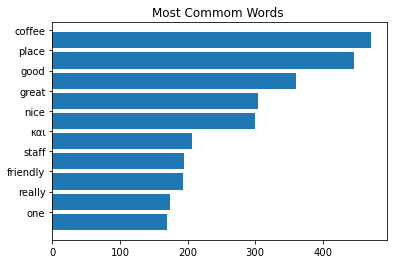

In [82]:
#Most common words - (NOT per class yet and sentiment/polarity)

topic_words = [ z.lower() for y in
                   [ x.split() for x in df['text'] if isinstance(x, str)]
                   for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(10), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:10])])
plt.yticks([x + 0.5 for x in range(10)], reversed(popular_words_nonstop[0:10]))
plt.title("Most Commom Words ")
plt.show()

# Question 3 - Create a box plot of user ratings visualizing the differences in ratings between user classes. Also, create a similar box plot for sentiment/polarity scores.


In [83]:
ratings_count_man = []
ratings_count_woman = []

for item in collection.find():
    reviewer = item['reviewer']
    try: 
        sex = reviewer['sex']
        if sex == 'woman':
            ratings_count_woman.append(item['review_rating']) 
        elif sex == 'man':   
            ratings_count_man.append(item['review_rating']) 
    except:
        None

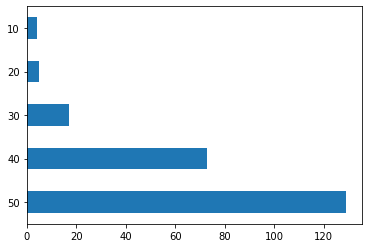

In [84]:
man_ratings_df =  pd.DataFrame(data = ratings_count_man)
man_ratings_df[0].value_counts().plot(kind='barh')

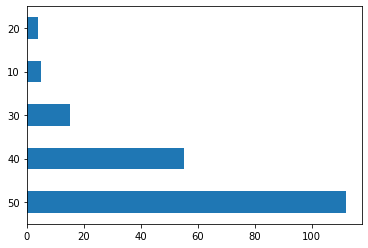

In [85]:
woman_ratings_df =  pd.DataFrame(data = ratings_count_woman)
woman_ratings_df[0].value_counts().plot(kind='barh')
